# Part 4 - Cluster Metro Areas
In this notebook, I will use KMeans to cluster the location data.  

<table style="width:100%">
    <tr>
        <td style="text-align: left">
            <h2>
                <a href="https://nbviewer.jupyter.org/github/KathrynDH/IBMCapstoneFinalProject/blob/master/Explore%20Location%20Data.ipynb">&larr; Part 3</a>
            </h2>
        </td>
        <td style="text-align: right">
            <h2>
                <a href="https://nbviewer.jupyter.org/github/KathrynDH/IBMCapstoneFinalProject/blob/master/Explore%20the%20Clusters.ipynb">Part 5 &rarr;</a>
            </h2>
        </td>
    </tr>
</table>

In [1]:
#import libraries
import requests
import numpy as np
import pandas as pd
import ibm_boto3
import io
from sklearn.cluster import KMeans
from datetime import datetime

In [2]:
# import plotting libraries
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# The code was removed by Watson Studio for sharing.

In [4]:
#Import the first venue dataframe
obj = resource.Object(bucket_name=bucket, key='VenueData.json').get()
df = pd.read_json(io.BytesIO(obj['Body'].read()))
df.sort_index(inplace=True)
df.head()

,Metropolitan,Country,Continent,Latitude,Longitude,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
0,Tokyo,Japan,Asia,35.682839,139.759455,Café,Japanese Restaurant,Italian Restaurant,Sushi Restaurant,Lounge,Garden,French Restaurant,Dessert Shop,Thai Restaurant,Steakhouse
1,Delhi,India,Asia,28.651718,77.221939,Indian Restaurant,Bar,Café,Flea Market,Lounge,Asian Restaurant,Ice Cream Shop,South Indian Restaurant,Portuguese Restaurant,Plaza
2,Mexico City,Mexico,North America,19.432601,-99.133342,Mexican Restaurant,Art Museum,Museum,Arts & Crafts Store,Bar,Ice Cream Shop,Boutique,Bakery,Restaurant,Café
3,São Paulo,Brazil,South America,-23.550651,-46.633382,Brazilian Restaurant,Japanese Restaurant,Café,Bakery,Snack Place,Bookstore,Cosmetics Shop,Asian Restaurant,Art Gallery,Chinese Restaurant
4,Lagos,Nigeria,Africa,6.455057,3.394179,Lounge,African Restaurant,Bar,Café,Shopping Mall,Pizza Place,Hotel,Art Gallery,Italian Restaurant,Market


In [5]:
#Import the venue dataframe used for clustering
obj = resource.Object(bucket_name=bucket, key='VenueOneHot.json').get()
df_onehot = pd.read_json(io.BytesIO(obj['Body'].read()))
df_onehot.head()

,Metro,ATM,Acai House,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Amphitheater,Antique Shop,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Yoshoku Restaurant,Zhejiang Restaurant,Zoo Exhibit
0,Ahmedabad,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
1,Alexandria,0.0,0.0,0.0,0.0,0.0,0.0,0.010309,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
10,Berlin/Brandenburg,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
11,Bogotá,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
12,Boston,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,...,0.0,0.0,0.01,0.0,0.0,0.0,0.02,0.0,0.0,0.0


### Find the cost for k values from 1 to max_k to determine the best k to use for KMeans clustering

In [9]:
# Find the best K for KMeans
max_k = 15
cost_vals = []
label_list = []
for k in range(1,max_k+1):
    model = KMeans(n_clusters=k, init='random').fit(df_onehot.drop('Metro',axis=1))
    cost_vals.append(model.inertia_)
    label_list.append(model.labels_)
    print('k:',k,' cost:', cost_vals[k-1])

k: 1  cost: 5.69746203116217
k: 2  cost: 5.110228949743916
k: 3  cost: 4.816327487654971
k: 4  cost: 4.573613800639876
k: 5  cost: 4.099757277232833
k: 6  cost: 4.134349737988096
k: 7  cost: 3.6764099454192407
k: 8  cost: 3.615772911136778
k: 9  cost: 3.522340812223514
k: 10  cost: 3.268764631085148
k: 11  cost: 3.163931528398157
k: 12  cost: 3.078618113835999
k: 13  cost: 2.9530199151422596
k: 14  cost: 2.8381317221461844
k: 15  cost: 2.9052009807943002


<function matplotlib.pyplot.show(*args, **kw)>

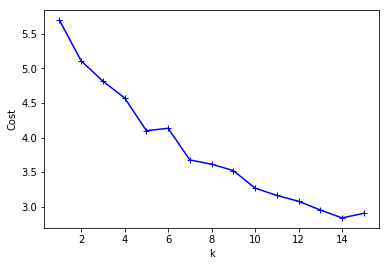

In [10]:
#plot the cost values for k and find the 'elbow' point
plt.plot(range(1,max_k+1),cost_vals,'b+-')

plt.xlabel('k')
plt.ylabel('Cost')
plt.show

There does not appear to be a clear 'elbow' in the graph. We are looking for a k value where the rate of decreasing cost slows down significantly.  
k=5 and k=7 look like good options. Let's look at those cluster sizes.

In [11]:
l = len(df_onehot.index)
for i in [5,7]:
    w = pd.DataFrame({'cat':label_list[i-1],'size':range(l)})
    print('k=',i,'\n',w.groupby('cat', as_index=False).count().sort_values('size', ascending=False))

k= 5 
    cat  size
0    0    48
2    2    22
4    4    15
1    1    14
3    3     1
k= 7 
    cat  size
3    3    68
6    6    12
5    5     8
1    1     5
2    2     3
4    4     3
0    0     1


After examining the results, k=5 seems to be a good choice for k.

In [21]:
#Add cluster labels
best_k = 5
df_onehot.insert(0, 'Cluster Labels', label_list[best_k-1])
df_onehot.head()

,Cluster Labels,Metro,ATM,Acai House,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Amphitheater,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Yoshoku Restaurant,Zhejiang Restaurant,Zoo Exhibit
0,1,Ahmedabad,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
1,2,Alexandria,0.0,0.0,0.0,0.0,0.0,0.0,0.010309,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
10,0,Berlin/Brandenburg,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
11,2,Bogotá,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0
12,0,Boston,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,...,0.0,0.0,0.01,0.0,0.0,0.0,0.02,0.0,0.0,0.0


In [22]:
#Add cluster labels
dftemp = df_onehot.iloc[:,[0,1]]
df_New = df.join(dftemp.set_index('Metro'), on='Metropolitan')
df_New.head()

,Metropolitan,Country,Continent,Latitude,Longitude,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10,Cluster Labels
0,Tokyo,Japan,Asia,35.682839,139.759455,Café,Japanese Restaurant,Italian Restaurant,Sushi Restaurant,Lounge,Garden,French Restaurant,Dessert Shop,Thai Restaurant,Steakhouse,2
1,Delhi,India,Asia,28.651718,77.221939,Indian Restaurant,Bar,Café,Flea Market,Lounge,Asian Restaurant,Ice Cream Shop,South Indian Restaurant,Portuguese Restaurant,Plaza,1
2,Mexico City,Mexico,North America,19.432601,-99.133342,Mexican Restaurant,Art Museum,Museum,Arts & Crafts Store,Bar,Ice Cream Shop,Boutique,Bakery,Restaurant,Café,0
3,São Paulo,Brazil,South America,-23.550651,-46.633382,Brazilian Restaurant,Japanese Restaurant,Café,Bakery,Snack Place,Bookstore,Cosmetics Shop,Asian Restaurant,Art Gallery,Chinese Restaurant,2
4,Lagos,Nigeria,Africa,6.455057,3.394179,Lounge,African Restaurant,Bar,Café,Shopping Mall,Pizza Place,Hotel,Art Gallery,Italian Restaurant,Market,0


In [23]:
df_New.loc[:,['Metropolitan','Country','Cluster Labels']].head(15)

,Metropolitan,Country,Cluster Labels
0,Tokyo,Japan,2
1,Delhi,India,1
2,Mexico City,Mexico,0
3,São Paulo,Brazil,2
4,Lagos,Nigeria,0
5,Mumbai,India,1
6,Cairo,Egypt,2
7,Kyoto,Japan,2
8,Wuhan,China,4
9,Los Angeles,United States,0


In [24]:
#Save dataframe to json file
resource.Bucket(name=bucket).put_object(Key='VenueDataWithClusters.json', Body=df_New.to_json())
print('Saved')

Saved


In [25]:
#make a backup of the file
t = datetime.now().strftime('%Y%m%d_%H%M')
resource.Bucket(name=bucket).put_object(Key='VenueDataWithClusters' + t + '.json', Body=df_New.to_json())
print('Saved ' + t)

Saved 20190914_2035


<table style="width:100%">
    <tr>
        <td style="text-align: left">
            <h2>
                <a href="https://nbviewer.jupyter.org/github/KathrynDH/IBMCapstoneFinalProject/blob/master/Explore%20Location%20Data.ipynb">&larr; Part 3</a>
            </h2>
        </td>
        <td style="text-align: right">
            <h2>
                <a href="https://nbviewer.jupyter.org/github/KathrynDH/IBMCapstoneFinalProject/blob/master/Explore%20the%20Clusters.ipynb">Part 5 &rarr;</a>
            </h2>
        </td>
    </tr>
</table>